# Comment Graph Analysis

In [1]:
import matplotlib.font_manager as font_manager
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns

sns.set_style("ticks")
fontpath = expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    'axes.labelsize': 9,
    'font.size': 9,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}
mpl.rcParams.update(params)


In [2]:
# Read channels
from helpers import bins_y_s, bins_t_s, colors, mean_confidence_interval
from sqlitedict import SqliteDict
import matplotlib.colors as cl
import networkx as nx
import pandas as pd
import numpy as np


def get_year(years_ts, years_nm, ts):
    for idx, (lower, upper) in enumerate(years_ts):
        if lower <= ts < upper:
            return years_nm[idx]
    return "Other"

cats = ["Alt-right", "Alt-lite", "Intellectual Dark Web"]
df_sources = pd.read_csv("../data/sources_final.csv")
df_sources = df_sources.set_index("Name")
channels_dict = SqliteDict("../data/channel_dict.sqlite", tablename="channels", flag="r")
df_important = pd.read_csv("../data/important_channels.csv")

## Optional: Recreate Graph

In [3]:
G = nx.read_graphml("../data/important_channels_intersection.graphml")

In [4]:
# Creates dataframe with similarity distribution
df_list = []
for edge in G.edges:
    i_n, j_n = sorted([edge[0], edge[1]], key=lambda x:df_sources.loc[x]["Category"])
    i, j = sorted([df_sources.loc[edge[0]]["Category"], df_sources.loc[edge[1]]["Category"]])
    
    if i == j:
        continue
        
    if i == "Alt-right":
        nar = j_n
    elif j == "Alt-right":
        nar = i_n
    else:
        nar = None
        
    j = j.replace("Intellectual Dark Web", "I.D.W.")
    i = i.replace("Intellectual Dark Web", "I.D.W.")
    ge = G.edges[edge]
    df_list.append({"nar": nar, "kind": "{} {}".format(i,j), "year": ge["year"], "weight": ge["weight"]})
    
df_sims = pd.DataFrame(df_list)


# Gets position from file created in gephi
df_helper_pos = pd.read_csv("../data/helper_comments.csv")
pos = {k: np.array([i["x"], i["y"]]) for k, i in df_helper_pos[["x", "y"]].iterrows()}
df_helper_imp = df_important.set_index("name")

/home/manoelribeiro/anaconda3/envs/community_fingerprinting/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/manoelribeiro/anaconda3/envs/community_fingerprinting/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/manoelribeiro/anaconda3/envs/community_fingerprinting/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/manoelribeiro/anaconda3/envs/community_fingerprinting/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


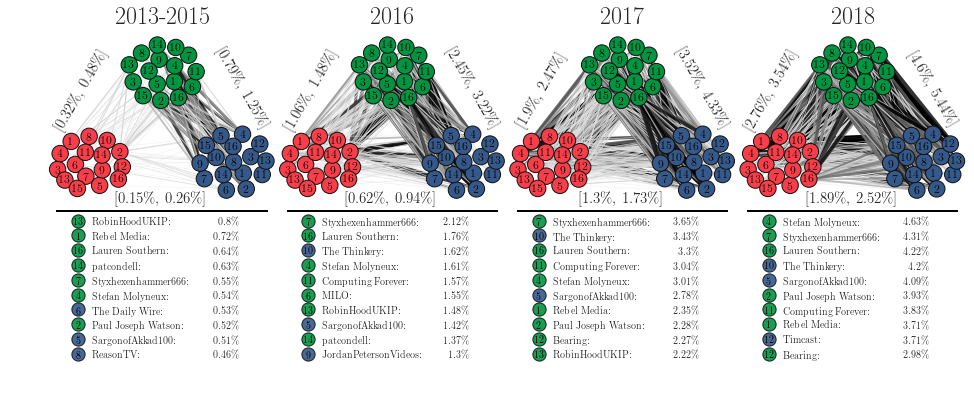

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(constrained_layout=False, figsize=(16.5,5.5))
gs = fig.add_gridspec(nrows=3, ncols=8, wspace=0.0, hspace=0, top=1)

for idx, year in enumerate(bins_t_s[1:]):

    ax_graph = fig.add_subplot(gs[0:4, idx*2:(idx+1)*2])
#     ax_bar = fig.add_subplot(gs[3:4, idx*2:(idx+1)*2])
    
    G_tmp = nx.Graph()
    G_tmp.add_nodes_from(G.nodes)
    G_tmp.add_edges_from([e for e in  G.edges.data() if e[2]["year"] == year and e[2]["weight"] > 0.01
                         and df_sources.loc[e[0]]["Category"] != df_sources.loc[e[1]]["Category"]])
    edges = G_tmp.edges()
    weights = [np.power(G_tmp[u][v]['weight'],1)*50 for u,v in edges]
    labels = {k: str(n["pos"]) for k, n in G.nodes().data()}
    node_color = [ cl.hex2color(colors[df_sources.loc[n]["Category"]]) for n in G.nodes()]
    nodes = nx.draw_networkx_nodes(G_tmp, pos, node_color=node_color, ax=ax_graph, node_size=270)
    nodes.set_edgecolor("#111111")
    edge_color = [plt.get_cmap("Greys")(w/(0.15*25)) for w in weights]
    nodes = nx.draw_networkx_edges(G_tmp, pos, width=weights, ax=ax_graph, 
                                   edge_color=edge_color, alpha=0.8)
    nodes = nx.draw_networkx_labels(G_tmp, pos, labels=labels, ax=ax_graph)

    intervals = { k: dict(v["weight"]) for k, v in
                 df_sims[df_sims.year == year].groupby("kind").agg(mean_confidence_interval).iterrows()}
    
    ax_graph.text(0, -1400, "[{}\%, {}\%]".format(round(intervals["Alt-right I.D.W."]["lower"]*100,2),
                                                round(intervals["Alt-right I.D.W."]["upper"]*100,2)), 
                  horizontalalignment="center",  verticalalignment="center", fontsize=15)
    
    ax_graph.text(-1150, 450, "[{}\%, {}\%]".format(round(intervals["Alt-lite Alt-right"]["lower"]*100,2),
                                                round(intervals["Alt-lite Alt-right"]["upper"]*100,2)), 
                  horizontalalignment="center",  verticalalignment="center", fontsize=15, rotation=60)
    ax_graph.text(1150, 450, "[{}\%, {}\%]".format(round(intervals["Alt-lite I.D.W."]["lower"]*100,2),
                                                round(intervals["Alt-lite I.D.W."]["upper"]*100,2)), 
                  horizontalalignment="center",  verticalalignment="center", fontsize=15, rotation=300)
       
    ax_graph.set_axis_off()
    ax_graph.set_title(year, fontsize=24)
    k = 10
    top_k = df_sims[(df_sims.nar != None) & (df_sims.year == year)].groupby("nar")\
                .mean().sort_values(by="weight", ascending=False).head(k)
    
    for idx, (name, weight) in enumerate(top_k.iterrows()):
        ax_graph.plot([-1500, 1500], [-1600, -1600], color="black")
        ax_graph.text(-1000, -1800 -idx*250, "{}:".format(name),
                      horizontalalignment="left",  verticalalignment="center", fontsize=10, weight=100)
        ax_graph.scatter([-1200], [-1770-idx*250], s=175, color=colors[df_sources.loc[name,"Category"]],
                        alpha=0.9, edgecolor="#111111")
        ax_graph.text(-1200, -1800 -idx*250, "{}".format(df_helper_imp.loc[name,"pos"]), color="black",
                      horizontalalignment="center",  verticalalignment="center", fontsize=10, fontweight=800)
        ax_graph.text(1100, -1800 -idx*250, "{}\%".format(round(weight.values[0]*100, 2)),
                      horizontalalignment="right",  verticalalignment="center", fontsize=10, weight=700)

    


fig.savefig("../imgs/graph_val.pdf", bbox_inches='tight')
